In [ ]:
!pip install PyWavelets

import pandas as pd
import os
import numpy as np
import librosa
import librosa.display
import pywt
import matplotlib.pyplot as plt

## Dataset Preparation
dataset used is guitar chord audio sample from a to g major, downloaded from: https://freesound.org/people/danglada/packs/1011/

In [ ]:
# audio files is located in /audio/*.wav
audio_files = [f for f in os.listdir('audio') if f.endswith('.wav')]

# to store every mfcc's step result
emphasis_result = []
framing_result = []
windowing_result = []
fft_result = []
filterbank_result = []

In [ ]:
# run optional for see the dataset detail
dataset = []
for audio in audio_files:
  y, sr = librosa.load(f"audio/{audio}")
  duration = librosa.get_duration(y=y, sr=sr)
  dataset.append({
    "title": audio,
    "sampling rate": sr,
    "duration (s)": round(duration, 2)
  })

pd.DataFrame(dataset)

,title,sampling rate,duration (s)
0,a-major.wav,22050,18.60
1,e-major.wav,22050,17.52
2,g-major.wav,22050,20.39
3,b-major.wav,22050,16.12
4,d-major.wav,22050,18.56
5,c-major.wav,22050,19.82
6,f-major.wav,22050,15.26


## Pre-emphasis

At this stage, all the audio data is applied the pre-emphasis function, in order for the high-frequency components of the sound signal to capture important information that helps distinguish the sound signal. The pre-emphasis coefficient (α) used is 0.97.

In [ ]:
pre_emphasis = 0.97

for audio in audio_files:
  y, sr = librosa.load(f"audio/{audio}")
  emphasis_result.append({
    "title": audio,
    "signal": np.append(y[0], y[1:] - pre_emphasis * y[:-1]),
    "sr": sr
  })

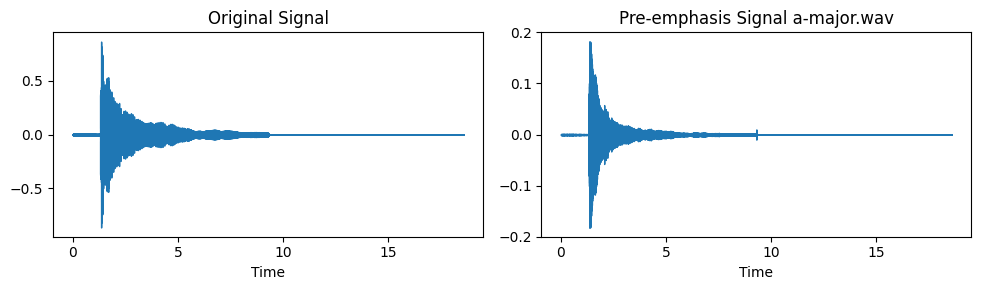

In [ ]:
y_original, sr_original = librosa.load(f"audio/{audio_files[0]}")

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
librosa.display.waveshow(y_original, sr=sr_original)
plt.title('Original Signal')

plt.subplot(1, 2, 2)
librosa.display.waveshow(emphasis_result[0]["signal"], sr=emphasis_result[0]['sr'])
plt.title(f'Pre-emphasis Signal {emphasis_result[0]["title"]}')

plt.tight_layout()

## Framing & Windowing

  Framing divides the pre-emphasized signal into small frames (usually 20-40 ms) to reduce the complexity of analysis. This process uses a Hamming window, which reduces the energy of the side lobes and prepares the signal for Fourier transform.

In [ ]:
frame_size = 0.025
frame_stride = 0.01

def framing(emphasized_signal, sr):
  frame_length, frame_step = frame_size * sr, frame_stride * sr  # Convert from seconds to samples
  signal_length = len(emphasized_signal)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  return pad_signal[indices.astype(np.int32, copy=False)]

for audio in emphasis_result:
  framing_result.append({
    "title": audio['title'],
    "signal": framing(audio['signal'], sr=audio['sr']),
    "sr": audio['sr']
  })

# apply hamming window for every frame
for audio in framing_result:
  windowing_result.append({
    "title": audio['title'],
    "signal": audio['signal'] * np.hamming(frame_size * audio['sr']),
    "sr": audio['sr']
  })


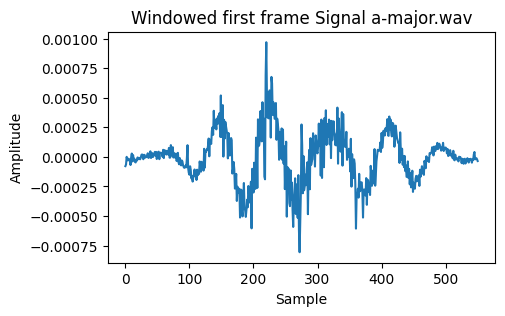

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(windowing_result[0]['signal'][0])
plt.title(f'Windowed first frame Signal {windowing_result[0]["title"]}')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

## Fast Fourier Transform (FFT)

Followed by converting the signal from the time domain to the frequency domain with Fast Fourier Transform (FFT), with the number of FFT samples used as many as 512.

In [ ]:
NFFT = 512

for audio in windowing_result:
  mag_frames = np.absolute(np.fft.rfft(audio['signal'], NFFT))  # Magnitude of the FFT
  pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
  fft_result.append({
    "title": audio['title'],
    "mag_frames": mag_frames,
    "pow_frames": pow_frames,
    "sr": audio['sr']
  })


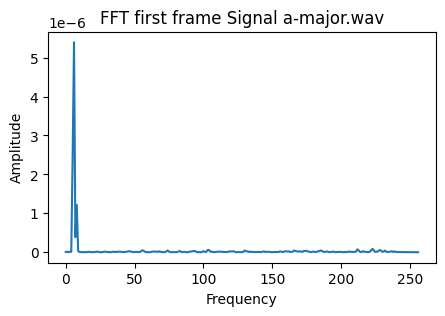

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(fft_result[0]["pow_frames"][0])
plt.title(f'FFT first frame Signal {windowing_result[0]["title"]}')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

## Mel Filterbank

The frequency results obtained from the Fast Fourier Transform (FFT) are then filtered using Mel Filterbank, with 20 filters used.

In [ ]:
nfilt = 20

def melbanks(pow_frames):
  low_freq_mel = 0
  high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
  hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
  bin = np.floor((NFFT + 1) * hz_points / sr)

  fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
  for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
      fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
      fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
  filter_banks = np.dot(pow_frames, fbank.T)
  filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
  return (20 * np.log10(filter_banks)), fbank

for audio in fft_result:
  final_melbanks, final_fbank = melbanks(audio['pow_frames'])
  filterbank_result.append({
    "title": audio['title'],
    "signal": final_melbanks,
    "fbank": final_fbank,
    "sr": audio['sr']
  })

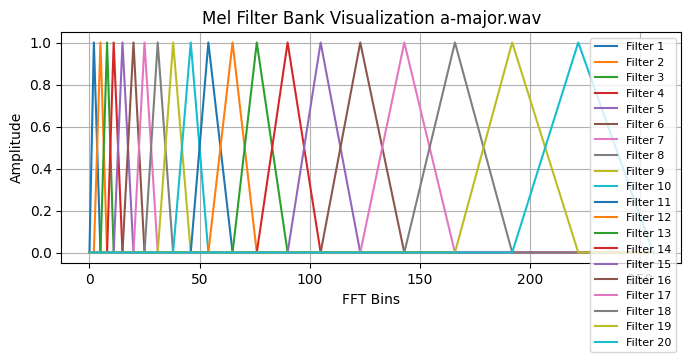

In [ ]:
plt.figure(figsize=(8, 3))
for i in range(nfilt):
    plt.plot(filterbank_result[0]['fbank'][i], label=f'Filter {i+1}')

plt.title(f'Mel Filter Bank Visualization {filterbank_result[0]["title"]}')
plt.xlabel('FFT Bins')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend(loc='upper right', fontsize=8)
plt.show()

## Discrete Wavelet Transform & Discrete Cosine Transform

Finally, at the feature extraction stage, the transformation of the Filterbank signal results is carried out. In this research, Discrete Wavelet Transform (DWT) and Discrete Cosine Transform (DCT) are used. In the Discrete Wavelet Transform (DWT), the wavelet family used is Daubechies (2) and in the Discrete Cosine Transform (DCT), the type of DCT used is type 2, with norm ortho.

> in this case, only first frame from each signal is applied

In [ ]:
using_frame=0
dataset = []
comparison_tabel = []
for audio in filterbank_result:
  dataset.append({
    "title": audio['title'],
    "signal": audio['signal'][using_frame],
    "sr": audio['sr']
  })


In [ ]:
pd.DataFrame(dataset)

,title,signal,sr
0,a-major.wav,"[-153.51513527610953, -104.15290585046623, -10...",22050
1,e-major.wav,"[-131.38296447321684, -155.2032264439357, -168...",22050
2,g-major.wav,"[-171.2364717188748, -175.33245976456212, -168...",22050
3,b-major.wav,"[-151.8772437940666, -159.49551203263547, -154...",22050
4,d-major.wav,"[-154.72171036332819, -163.26042601864148, -15...",22050
5,c-major.wav,"[-142.4265084187422, -153.13315927536382, -155...",22050
6,f-major.wav,"[-166.4268000312563, -152.10347614203772, -157...",22050


In [ ]:
# apply dct & dwt for frame
for audio in dataset:
  original_signal = audio['signal']

  # dct
  f_dct = librosa.feature.mfcc(S=[original_signal], sr=audio['sr'], n_mfcc=nfilt)[0]

  #dwt
  cA, cD = pywt.dwt(original_signal, 'db2')
  f_dwt = pywt.idwt(cA, cD, 'db2')

  comparison_tabel.append({
    "title": audio['title'],
    "original_signal": original_signal,
    "dwt": f_dwt,
    "dct": f_dct
  })

pd.DataFrame(comparison_tabel)

,title,original_signal,dwt,dct
0,a-major.wav,"[-153.51513527610953, -104.15290585046623, -10...","[-153.51513527610953, -104.15290585046623, -10...","[-153.51513527610956, -104.15290585046624, -10..."
1,e-major.wav,"[-131.38296447321684, -155.2032264439357, -168...","[-131.38296447321684, -155.20322644393573, -16...","[-131.38296447321687, -155.20322644393573, -16..."
2,g-major.wav,"[-171.2364717188748, -175.33245976456212, -168...","[-171.23647171887484, -175.33245976456215, -16...","[-171.23647171887484, -175.33245976456215, -16..."
3,b-major.wav,"[-151.8772437940666, -159.49551203263547, -154...","[-151.87724379406663, -159.4955120326355, -154...","[-151.87724379406663, -159.4955120326355, -154..."
4,d-major.wav,"[-154.72171036332819, -163.26042601864148, -15...","[-154.72171036332819, -163.26042601864154, -15...","[-154.7217103633282, -163.2604260186415, -158...."
5,c-major.wav,"[-142.4265084187422, -153.13315927536382, -155...","[-142.42650841874223, -153.13315927536385, -15...","[-142.42650841874223, -153.13315927536385, -15..."
6,f-major.wav,"[-166.4268000312563, -152.10347614203772, -157...","[-166.42680003125633, -152.10347614203775, -15...","[-166.42680003125633, -152.10347614203775, -15..."


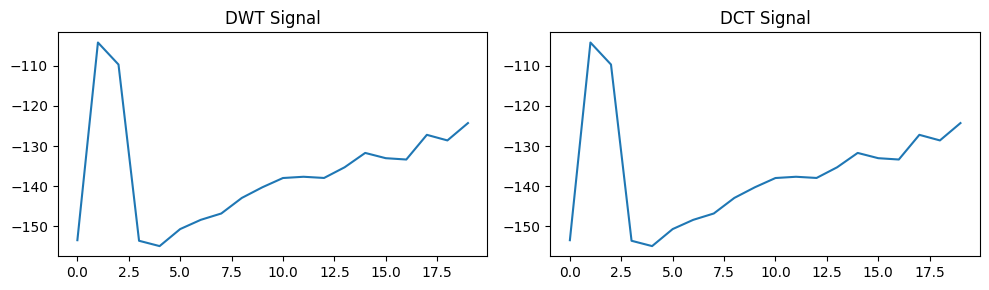

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(comparison_tabel[0]['dwt'])
plt.title('DWT Signal')

plt.subplot(1, 2, 2)
plt.plot(comparison_tabel[0]['dct'])
plt.title('DCT Signal')

plt.tight_layout()

## Peak Signal-to-Noise Ratio (PSNR)

Peak Signal to Noise Ratio (PSNR) is a measure used to assess the quality of a signal that has been reconstructed or compressed compared to the original signal. In digital image processing, PSNR is often used to measure the quality of image compression or reconstruction results.

In [ ]:
reconstructed = []
final_result = []
for audio in comparison_tabel:
  noise_level = 1e-6
  dwt_reconstructed = audio['dwt'] + noise_level * np.random.normal(size=audio['dwt'].shape)
  dct_reconstructed = audio['dct'] + noise_level * np.random.normal(size=audio['dct'].shape)
  reconstructed.append({
    "title": audio['title'],
    "original_signal": audio['original_signal'],
    "dwt": dwt_reconstructed,
    "dct": dct_reconstructed
  })

In [ ]:
from math import log10, sqrt

def PSNR(original, compressed):
  mse = np.mean((original - compressed) ** 2)
  if(mse == 0):
    return 100
  max_pixel = 255.0
  psnr = 20 * log10(max_pixel / sqrt(mse))
  return psnr

In [ ]:
for audio in reconstructed:
  final_result.append({
    "title": audio['title'],
    "dwt_psnr": PSNR(audio['original_signal'], audio['dwt']),
    "dct_psnr": PSNR(audio['original_signal'], audio['dct']),
  })


In [ ]:
pd.DataFrame(final_result).describe()

,dwt_psnr,dct_psnr
count,7.000000,7.000000
mean,168.457168,168.673390
std,1.110324,1.639787
min,167.643116,166.341403
25%,167.857489,168.187018
50%,168.136405,168.329996
75%,168.425004,168.922085
max,170.855673,171.824127
